In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Business Problem

##### Due to the rising number of COVID-19 cases, our group is thinking of developing a solution that can quickly identify if one gets affected by covid-19 or other lung diseases by analyzing the patient’s lung image through the help of the neural network. Besides demonstrating detection of COVID-19 affected lungs, our group is also trying to detect the region of lungs affected by COVID-19. 

##### Most of the previous models are classified between COVID-19 affected and healthy lungs. However, in a real-life scenario, a patient might get affected by another lung disease but labeled as COVID-19 or vice versa due to the similarities of the lung image. We do not want patients to go through the wrong treatment, and thus, we decided to add a multi-label classifier in our model. In this case, we can handle the problem of classifying COVID-19 affected lungs from other different lung diseases by focusing more on overall lung disease classification than classifying among healthy and COVID affected. 


In [ ]:
# Import packages
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image, ImageDraw
import glob
import numpy as np
import os
import random
import shutil
import csv
import numpy as np
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

# Data Preparation

In [ ]:
! git clone https://github.com/Jiajiazhi/865data/

Cloning into '865data'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21 (delta 1), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [ ]:
#Unzip the file
import zipfile
zip_ref=zipfile.ZipFile('/content/865data/Desktop/BA865.zip','r')
for names in zip_ref.namelist():
              f = zip_ref.extract(names, './865data')  # 解压到zip目录文件下
      
zip_ref.close()  


In [ ]:
# set the base dictionary
base_dir = "drive/Shareddrives/BA865"

# Create train, test, validation dataset from image files to dictionary 
dataset_train = image_dataset_from_directory(
    base_dir + "/pic/train/",
    image_size=(180, 180),
    batch_size=32,
    label_mode="categorical")

dataset_test = image_dataset_from_directory(
    base_dir + "/pic/test/",
    image_size=(180, 180),
    batch_size=32,
    label_mode="categorical")

dataset_val = image_dataset_from_directory(
    base_dir + "/pic/validation/",
    image_size=(180, 180),
    batch_size=32,
    label_mode="categorical")

Found 598 files belonging to 2 classes.
Found 148 files belonging to 2 classes.
Found 372 files belonging to 2 classes.


In [ ]:
# Check data shape
for data_batch, labels_batch in dataset_train:
     print("data batch shape:", data_batch.shape)
     print("labels batch shape:", labels_batch.shape)
     print(labels_batch)
     break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32, 3)
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]], shape=(32, 3), dtype=float32)


In [ ]:
# Shuffle and split data into train,test,validation dataset by moving images into different folders
# Only need to execute once


# imageDir: Location of covid/non-covid images
# test_rate/val_rate: Proportion of images assigned to test/validation 
# test_dir/train_dir/val_dir: The location for image that after moving from the COVID/NonCovid dataset to the test/train/validation dataset
def CopyFile(imageDir,test_rate,val_rate,test_dir,train_dir,val_dir):
    image_number = len(imageDir)  # Total number of images
    test_number = int(image_number * test_rate) # Number of images need to move
    val_number = int(image_number * val_rate)
    test_samples = random.sample(imageDir, test_number) # Randomly select 'test_number' of images in imageDir as test samples 
    val_samples = random.sample(imageDir, val_number) # Randomly select 'val_number' of images in imageDir as validation samples 
    # Copy image to target folder
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        print("save_test_dir has been created successfully!")
    else:
        print("save_test_dir already exist!")
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
        print("save_train_dir has been created successfully!")
    else:
        print("save_train_dir already exist!")
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
        print("save_val_dir has been created successfully!")
    else:
        print("save_val_dir already exist!")
    for i,j in enumerate(test_samples):
        shutil.copy(test_samples[i], test_dir+test_samples[i].split("/")[-1])
    print("test succefully moved! ")
    for i,j in enumerate(val_samples):
        shutil.copy(val_samples[i], val_dir+val_samples[i].split("/")[-1])
    print("validation succefully moved！")
    for train_imgs in imageDir:
        if train_imgs not in test_samples:
            shutil.copy(train_imgs, train_dir+train_imgs.split("/")[-1])
    print("train succefully moved！")

test_rate=0.2
val_rate = 0.5
# Define file path
test_rate=0.2
val_rate = 0.5
file_path='/content/865data/BA865'

file_dirs=os.listdir(file_path)
origion_paths=[]
test_dirs=[]
train_dirs=[]
val_dirs=[]

# Move images to sepreate path based on train/test/validation
for path in file_dirs:
   if path != '.DS_Store':
      origion_paths.append(file_path+"/"+path+"/")
      train_dirs.append(file_path+"/data/train/"+path+"/")
      test_dirs.append(file_path+"/data/test/"+path+"/")
      val_dirs.append(file_path+'/data/validation/'+path+'/')
for i,origion_path in enumerate(origion_paths):
    image_list = os.listdir(origion_path) # Obtain all image name under the original path
    image_Dir=[]
    for x,y in enumerate(image_list):
        image_Dir.append (os.path.join(origion_path, y))
    CopyFile(image_Dir,test_rate,val_rate,test_dirs[i],train_dirs[i],val_dirs[i])
print("all datas has been moved successfully!")


save_test_dir has been created successfully!
save_train_dir has been created successfully!
save_val_dir has been created successfully!
test succefully moved! 
validation succefully moved！
train succefully moved！
save_test_dir has been created successfully!
save_train_dir has been created successfully!
save_val_dir has been created successfully!
test succefully moved! 
validation succefully moved！
train succefully moved！
all datas has been moved successfully!


# Build Model

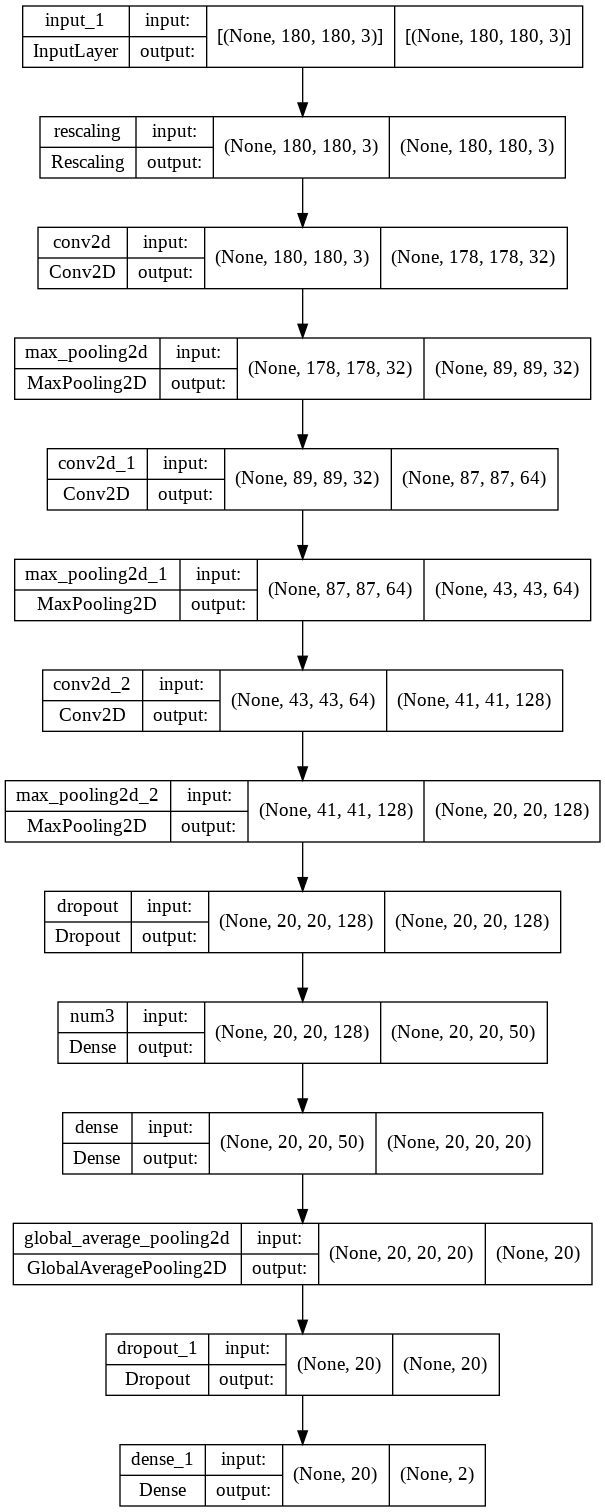

In [ ]:
# Becasue we have a small sample size, we decided to implement data augmentation
data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])

# Build models
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="elu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="PReLU")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="PReLU")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Dropout(0.2)(x)
x = keras.layers.Dense(50, activation="relu", name="num3")(x)
x = keras.layers.Dense(20, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2, activation="sigmoid")(x) # binary classification
model = keras.Model(inputs=inputs, outputs=outputs)

# Plot our model
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# record model with best performance
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Xception.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [ ]:
# Train model
num_epochs=80
batch_sizes=25
    
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    dataset_train,
    epochs=num_epochs, 
    batch_size=batch_sizes,
    validation_data=dataset_val,
    callbacks=callbacks)

Epoch 1/80
19/19 [==============================] - 143s 6s/step - loss: 0.6957 - accuracy: 0.5385 - val_loss: 0.6955 - val_accuracy: 0.5323
Epoch 2/80
19/19 [==============================] - 53s 3s/step - loss: 0.6938 - accuracy: 0.5368 - val_loss: 0.6857 - val_accuracy: 0.5323
Epoch 3/80
19/19 [==============================] - 52s 3s/step - loss: 0.6880 - accuracy: 0.5318 - val_loss: 0.6743 - val_accuracy: 0.5323
Epoch 4/80
19/19 [==============================] - 53s 3s/step - loss: 0.6835 - accuracy: 0.5318 - val_loss: 0.6622 - val_accuracy: 0.5430
Epoch 5/80
19/19 [==============================] - 54s 3s/step - loss: 0.6793 - accuracy: 0.5385 - val_loss: 0.6536 - val_accuracy: 0.5430
Epoch 6/80
19/19 [==============================] - 54s 3s/step - loss: 0.6749 - accuracy: 0.5552 - val_loss: 0.6477 - val_accuracy: 0.5457
Epoch 7/80
19/19 [==============================] - 55s 3s/step - loss: 0.6704 - accuracy: 0.5870 - val_loss: 0.6416 - val_accuracy: 0.5484
Epoch 8/80
19/19 [=

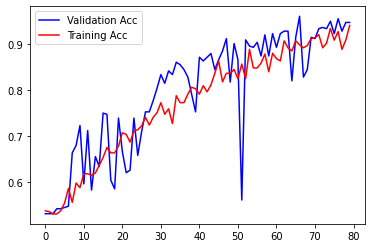

In [ ]:
#Plot model performance
plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

In [ ]:
# Check accuracy on test set
test_model = keras.models.load_model("Xception.keras")
test_loss, test_acc = test_model.evaluate(dataset_test) 
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 26s 566ms/step - loss: 0.5467 - accuracy: 0.7568
Test accuracy: 0.7567567825317383


The best test accuracy is 75.68, which is enough for primary identification and screening.

In [ ]:
#Build a confusion matirx to 
predictions = np.array([])
labels =  np.array([])
for x, y in dataset_test:
  predictions = np.concatenate([predictions, np.argmax(test_model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [ ]:
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[55, 14],
       [22, 57]], dtype=int32)

# Conclusion 
From the fact that due to the COVID outbreak, the workload of doctors has increased greatly, and they have to examine many lungs CTs every day, the goal of our project is to use neural networks to analyze patients' lung CTs to quickly determine if they have COVID.

Our model has an accuracy of 78.38%, which can help doctors improve their efficiency. Patients with symptomatic lungs detected by the neural network can be sent directly to the hospital for further evaluation, while doctors only need to examine CTs judged by the neural network to be asymptomatic to determine if the patient is at risk of getting COVID.

We got 71% recall rate by confusion matrix, which means there is still false negative, and the neural network filtered out some of the true positive COVID. So, the project and dataset still need to be improved in the future, such as increasing the number of data, and more CTs can be used as modeling objects. But in general, as a result, our model did reduce the workload of doctors, improve the efficiency, and reduce the cost of healthcare.